# VAR Model: energy prices and inflation
We assume a relationship between the energy prices and inflation. We model such relationship in order to predict a variation of inflation from a variation of the energy prices. We use the prices of natural gas and the inflation for Italy from January 2016 to December 2023. For the energy price we use the data for the natural gas from the International Monetary Fund (IMF). From the [IMF website](https://data.imf.org/?sk=471dddf8-d8a7-499a-81ba-5b332c01f8b9) we select the Natural Gas Netherlands TFF dataset as the commodity in US dollars. For the inflation we use the general index for Italy from [ISTAT](http://dati.istat.it/). Since the energy prices can affect the inflation and, vice versa, the inflation can affect the energy prices, we use the vector autoregressive (VAR) model to represent the processes and their interaction. The VAR model is an extension of the autoregressive model AR(p). 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## Natural Gas - Netherlands TFF

In [2]:
imf_commodities_path = 'data/imf_commodities.csv'
imf_commodities_tmp = pd.read_csv(imf_commodities_path)
imf_commodities_tmp.head(2)

,Country Name,Country Code,Commodity Name,Commodity Code,Unit Name,Unit Code,Attribute,2015M1,2015M2,2015M3,...,2023M4,2023M5,2023M6,2023M7,2023M8,2023M9,2023M10,2023M11,2023M12,Unnamed: 115
0,World,1,Industrial Materials index,PINDU,Index,IX,Value,115.697669,112.891399,110.187288,...,168.360791,156.684029,156.434364,157.406576,154.700611,159.823049,157.575786,163.444974,165.612251,NaN
1,World,1,Non-Fuel index,PNFUEL,Index,IX,Value,108.401507,105.827424,102.837085,...,155.829121,148.774443,145.943374,146.109110,142.639895,143.647360,143.546099,148.093495,148.636510,NaN


In [58]:
natural_gas_tmp = imf_commodities_tmp[(imf_commodities_tmp['Commodity Code'] == 'PNGAS') & (imf_commodities_tmp['Unit Code'] == 'IX')]
nat_gas_values = natural_gas_tmp.loc[natural_gas_tmp.index, '2016M1':'2023M12'].values[0]

In [59]:
month_index = pd.date_range('2016-01-01', '2024-01-01', freq='M')

In [60]:
len(month_index)

96

In [61]:
nat_gas_df = pd.DataFrame({'Price': nat_gas_values}, index=month_index)
nat_gas_df.tail(2)

,Price
2023-11-30,213.975925
2023-12-31,178.077808


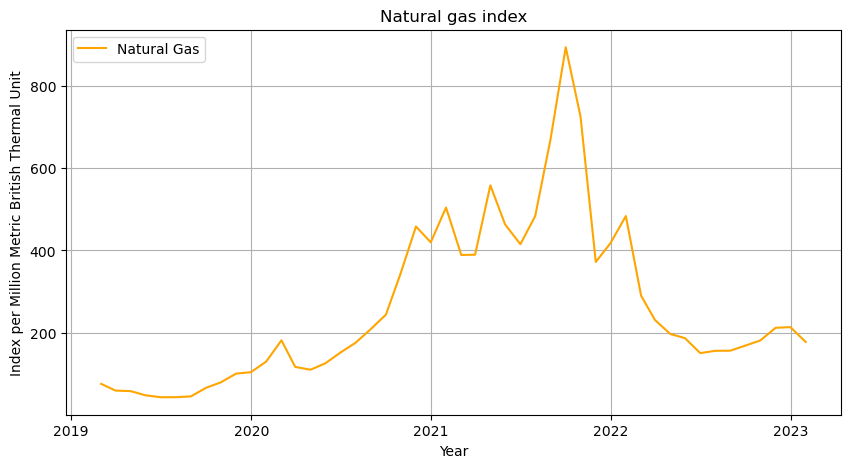

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Natural gas index")
ax.set_xlabel("Year")
ax.set_ylabel("Index per Million Metric British Thermal Unit");
ax.set_xticks(month_index)
#ax.set_xticklabels(month_index, rotation=70)
#ax.set_yticks(np.arange(0, 60, 2), minor=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator(12))
ax.grid(True)
ax.plot(nat_gas_df['2020':'2023'], label='Natural Gas', color='orange')
plt.legend(loc='upper left')

## Inflation

In [76]:
inflation_italy_path = 'data/istat_indice_prezzi_al_consumo_nic.csv'
inflation_italy_tmp = pd.read_csv(inflation_italy_path, usecols=['TIME', 'Value', 'Misura'])
inflation_italy_num_indici = inflation_italy_tmp[inflation_italy_tmp['Misura'] == 'numeri indici'][['TIME', 'Value']]
inflation_italy_num_indici.head(2)

,TIME,Value
0,2016-01,99.6
1,2016-02,99.4


In [81]:
inflation_df = pd.DataFrame({'Index': inflation_italy_num_indici['Value'].to_list()}, index=month_index)
inflation_df.head(2)

,Index
2016-01-31,99.6
2016-02-29,99.4


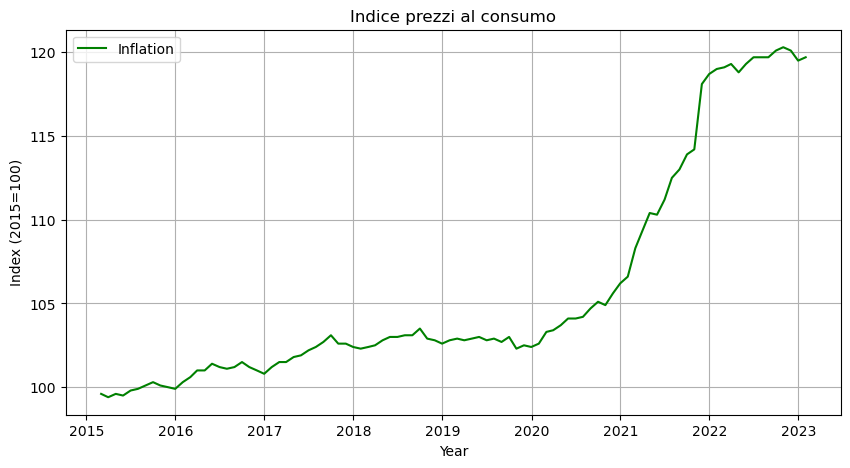

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Indice prezzi al consumo")
ax.set_xlabel("Year")
ax.set_ylabel("Index (2015=100)");
ax.set_xticks(month_index)
#ax.set_xticklabels(month_index, rotation=70)
#ax.set_yticks(np.arange(0, 60, 2), minor=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator(12))
ax.grid(True)
ax.plot(inflation_df, label='Inflation', color='green')
plt.legend(loc='upper left')
plt.savefig('inflation_italy_2016_2023')

## The VAR model
In an autoregressive process the output variable $y_t$ depends linearly on its previous values

$$y_t = \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + .. + \phi_p y_{t-p} + \epsilon_t$$

where $\delta$ is a constant and $\epsilon_t$ an error term. The index p represents the order of the autoregressive process AR(p), that is the number of previous values that are taken into account to predict the actual value of the output. For example, the output variable of an autoregressive process of order 1 is represented by

$$y_t = \delta + \phi_1 y_{t-1} + \epsilon_t$$

We can represent a process of two variables with an AR model adding for each variable its dependency on the other. For a model of order 1, i.e. p=1, we can represent the system of two variables 

$$y_{1,t} = \delta_1 + \phi_{1, 1} y_{1, t-1} + + \phi_{1, 2} y_{2, t-1} + \epsilon_{1, t}$$
$$y_{2,t} = \delta_2 + \phi_{2, 1} y_{1, t-1} + + \phi_{2, 2} y_{2, t-1} + \epsilon_{2, t}$$

or in matrix form

$$ \left (  \right )$$